In [18]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from WeightedBinaryCrossentropy import WeightedBinaryCrossentropy

In [19]:
data = pd.read_csv(r'..\Data\power_outage_data.csv')
data.drop(columns=['location'], inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp')
X = data.loc[:,'temperature':'precipitation']
y = data.loc[:,'power_outage']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05,shuffle=False,random_state=0)
X_train.reset_index(inplace=True, drop = True)
X_test.reset_index(inplace= True, drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      8857 non-null   datetime64[ns]
 1   temperature    8857 non-null   float64       
 2   humidity       8857 non-null   float64       
 3   wind_speed     8857 non-null   float64       
 4   precipitation  8857 non-null   float64       
 5   power_outage   8857 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 415.3 KB


In [20]:
def prepro(X):    
    scaler = MinMaxScaler()
    scaler.fit(X_train.loc[:,'temperature':])
    X_scaled = scaler.transform(X.loc[:,'temperature':])
    X_t = pd.DataFrame(X_scaled)
    return X_t.to_numpy()

In [21]:
X_te = prepro(X_test)
X_tr = prepro(X_train)
X_te.shape

(443, 4)

In [22]:
gen_train = tfk.preprocessing.sequence.TimeseriesGenerator(np.asarray(X_tr), np.asarray(y_train), length = 4, sampling_rate = 1, batch_size = 32, stride = 1)
gen_test = tfk.preprocessing.sequence.TimeseriesGenerator(np.asarray(X_te), np.asarray(y_test), length = 4, sampling_rate = 1, batch_size = 32, stride = 1)


In [23]:
model = tfk.Sequential()
model.add(tfk.Input(shape = (4,4)))
model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(128, return_sequences=True)))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dropout(0.3))
model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(256, return_sequences=True)))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dropout(0.3))
model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(256, return_sequences=True)))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dropout(0.3))
model.add(tfk.layers.LSTM(128, return_sequences=False))
model.add(tfk.layers.ReLU())
model.add(tfk.layers.Dense(1))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 4, 256)           136192    
 nal)                                                            
                                                                 
 re_lu_4 (ReLU)              (None, 4, 256)            0         
                                                                 
 dropout_3 (Dropout)         (None, 4, 256)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 4, 512)           1050624   
 nal)                                                            
                                                                 
 re_lu_5 (ReLU)              (None, 4, 512)            0         
                                                                 
 dropout_4 (Dropout)         (None, 4, 512)           

In [25]:
1 - data['power_outage'].mean()

0.757254149260472

In [26]:
early_stop = tfk.callbacks.EarlyStopping(monitor = 'accuracy',patience=2,mode='min')
model.compile(loss = WeightedBinaryCrossentropy(weights = [1,6]), optimizer= tfk.optimizers.Adam(), metrics=['accuracy'])

In [29]:
history = model.fit(gen_train,epochs=10,shuffle=False, callbacks= [early_stop])

Epoch 1/10
263/263 [==============================] - 31s 69ms/step - loss: 0.3103 - accuracy: 0.9283
Epoch 2/10
263/263 [==============================] - 18s 67ms/step - loss: 0.7612 - accuracy: 0.8380
Epoch 3/10
263/263 [==============================] - 18s 67ms/step - loss: 0.4792 - accuracy: 0.9026
Epoch 4/10
263/263 [==============================] - 18s 68ms/step - loss: 0.3639 - accuracy: 0.9093


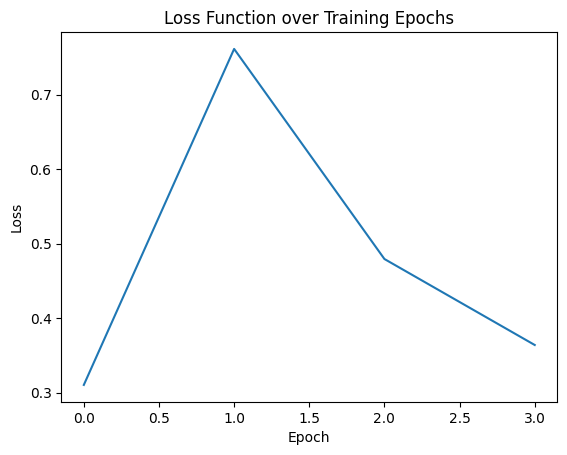

[0.31027206778526306,
 0.7611771821975708,
 0.4792417287826538,
 0.36385855078697205]

In [30]:
loss_values = history.history['loss']

# Plot the loss function graph
plt.plot(loss_values)
plt.title('Loss Function over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
loss_values

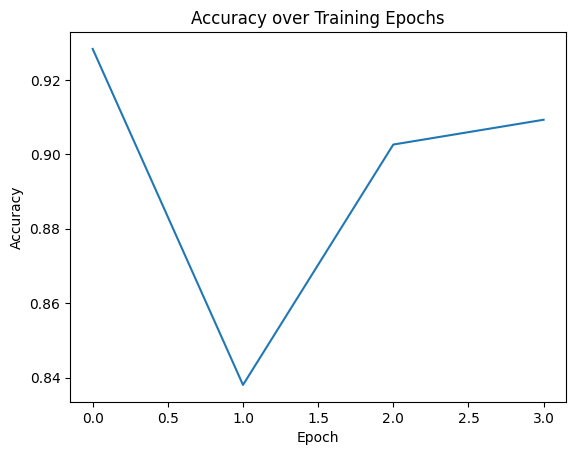

In [31]:
acc_values = history.history['accuracy']

# Plot the loss function graph
plt.plot(acc_values)
plt.title('Accuracy over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [32]:
model.evaluate(gen_test)

14/14 [==============================] - 3s 17ms/step - loss: 0.2266 - accuracy: 0.9180


[0.2266424149274826, 0.9179954528808594]

In [33]:
def plot_roc_curve(y_test, y_prob):

    fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

14/14 [==============================] - 3s 16ms/step


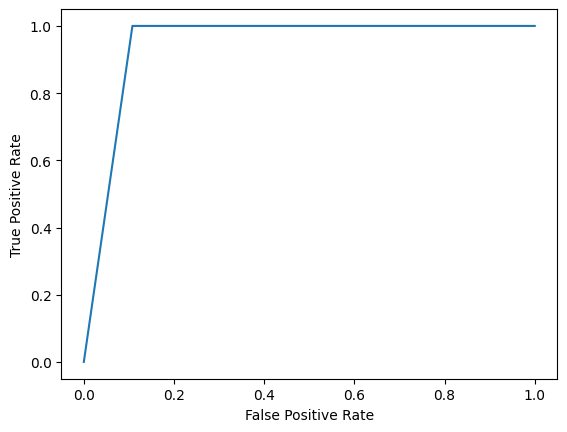

In [34]:
yhat = model.predict(gen_test)
yhat = [1 if x>0.5  else 0 for x in yhat]
plot_roc_curve(y_test[4:],yhat)

F1 measure: 0.8536585365853657
ROC AUC: 0.9461077844311377


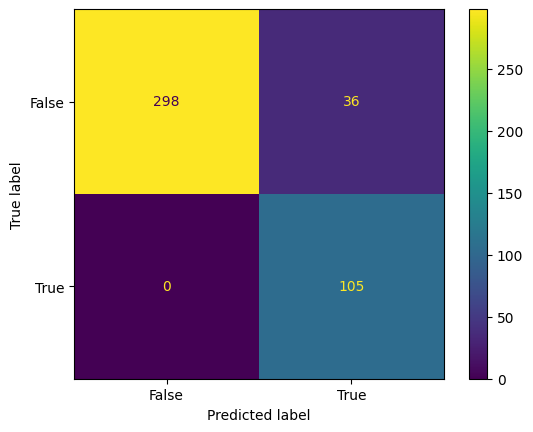

In [35]:
confusion_matrix_test = metrics.confusion_matrix(y_test[4:],yhat)
cmt = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
print(f'F1 measure: {metrics.f1_score(y_test[4:],yhat)}\nROC AUC: {metrics.roc_auc_score(y_test[4:],yhat)}')
cmt.plot()
plt.show()

0.7608200455580865


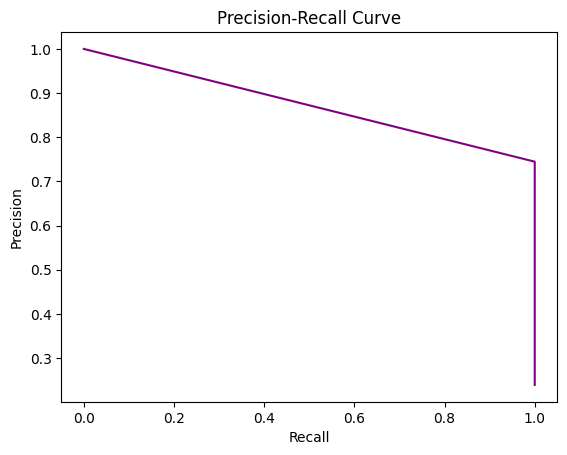

In [36]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test[4:], yhat)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
print(ax.get_data_ratio())

#display plot
plt.show()

In [11]:
### model.save_weights(r'..\Pretrained Weights\po_hour')

In [27]:
# model.load_weights(r'..\Pretrained Weights\po_hour')